# Locating lymph node cell types with the integrated immune organ referece

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib as mpl
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import glob
from re import sub

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps

## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/data/b_t_cells_tonsils_hk/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'

sp_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'
run_name = 'CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'

Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [3]:
help(sc.datasets.visium_sge)

Help on function visium_sge in module scanpy.datasets._datasets:

visium_sge(sample_id: typing_extensions.Literal['V1_Breast_Cancer_Block_A_Section_1', 'V1_Breast_Cancer_Block_A_Section_2', 'V1_Human_Heart', 'V1_Human_Lymph_Node', 'V1_Mouse_Kidney', 'V1_Adult_Mouse_Brain', 'V1_Mouse_Brain_Sagittal_Posterior', 'V1_Mouse_Brain_Sagittal_Posterior_Section_2', 'V1_Mouse_Brain_Sagittal_Anterior', 'V1_Mouse_Brain_Sagittal_Anterior_Section_2'] = 'V1_Breast_Cancer_Block_A_Section_1') -> anndata._core.anndata.AnnData
    Processed Visium Spatial Gene Expression data from 10x Genomics.
    Database: https://support.10xgenomics.com/spatial-gene-expression/datasets
    
    Parameters
    ----------
    sample_id
        The ID of the data sample in 10x’s spatial database.
    
    Returns
    -------
    Annotated data matrix.



In [4]:
adata = sc.datasets.visium_sge('V1_Human_Lymph_Node')
sc.pp.calculate_qc_metrics(adata, inplace=True)

slides = {'LN': adata}

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Now let's look at QC: total number of counts and total number of genes per spot

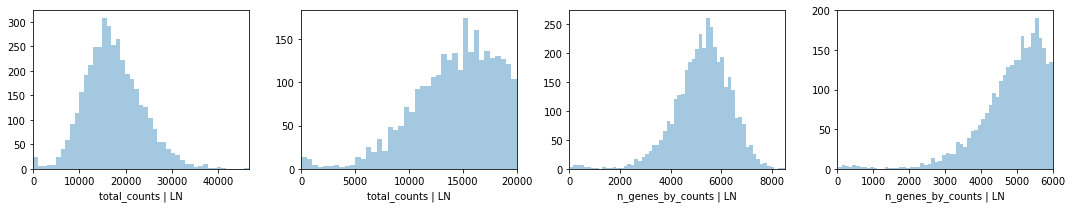

In [5]:
# PLOT QC FOR EACH SAMPLE 
if len(slides) > 2:
    figsize = 4*len(slides)-4
else:
    figsize = 4*len(slides)-1
    
fig, axs = plt.subplots(len(slides), 4, figsize=(15, figsize))
axs = axs.reshape((len(slides), 4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

... storing 'feature_types' as categorical
... storing 'genome' as categorical


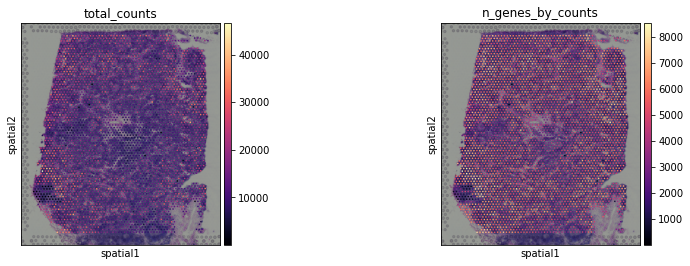

In [6]:
sc.pl.spatial(slides['LN'], img_key = "hires", cmap='magma',
              color=['total_counts', 'n_genes_by_counts'],
              gene_symbols='SYMBOL', size=0.8)

Here we show how to use scanpy to plot results over histology section using anndata object from one section, and 

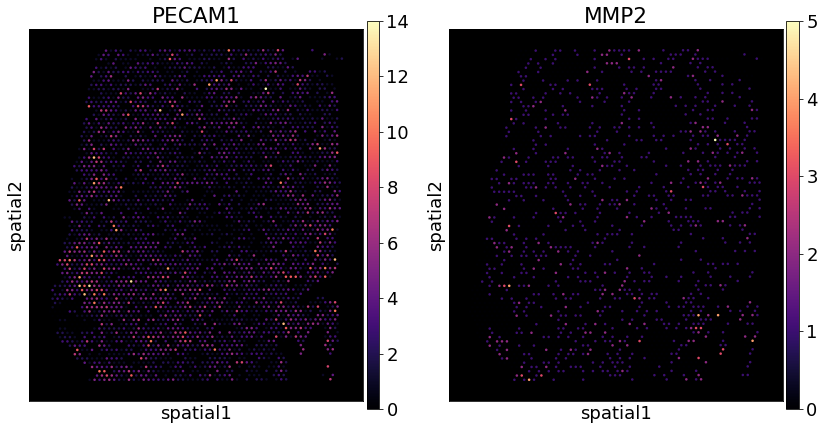

In [7]:
rcParams["axes.facecolor"] = "black"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(adata, 
              color=["PECAM1", "MMP2"], img_key='hires', alpha_img=0,
              vmin=0, cmap='magma', #vmax=3.8,
              gene_symbols='SYMBOL', size=0.8
             )

In [8]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
# read region annotation for each location
manual_GC_annot = pd.read_csv(f'{sp_results_folder}{run_name}/manual_GC_annot.csv', index_col=0)
manual_GC_annot['GC'][manual_GC_annot['GC'].isna()] = 'other'
manual_GC_annot['GC'].value_counts()

other    3657
GC        378
Name: GC, dtype: int64

In [10]:
ind = manual_GC_annot.index.isin(adata_vis.obs_names)
ind = manual_GC_annot.index[ind]
adata_vis = adata_vis[ind,:]
adata_vis.obs['supervised_region'] = manual_GC_annot.loc[ind, 'GC']

# remove other group
#adata_vis = adata_vis[~adata_vis.obs['supervised_region'].isin(['other']),:]

# read region annotations for each cell type
gold_standard = pd.read_csv(f'{sp_results_folder}{run_name}/gold_standard_annotation_subtypes_to_regions.csv',
                            index_col=0)
gold_standard = gold_standard.loc[gold_standard.isna().sum(1) == 0,]
gold_standard.index = [f'gold_standard_{i}' for i in gold_standard.index]

# remove other group
gold_standard = gold_standard.loc[~gold_standard['label'].isin(['other', 'T-cell zone']),:]

for ct in gold_standard.index:
    adata_vis.obs[ct] = adata_vis.obs['supervised_region'].isin([gold_standard.loc[ct, 'label']]).astype(float)
    
adata_vis.obs[gold_standard.index]

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,gold_standard_B_Cycling,gold_standard_B_GC_DZ,gold_standard_B_GC_LZ,gold_standard_B_GC_prePB,gold_standard_FDC,gold_standard_T_CD4+_TfH_GC
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTGTATTACACG-1,0.0,0.0,0.0,0.0,0.0,0.0


... storing 'sample' as categorical
... storing 'supervised_region' as categorical


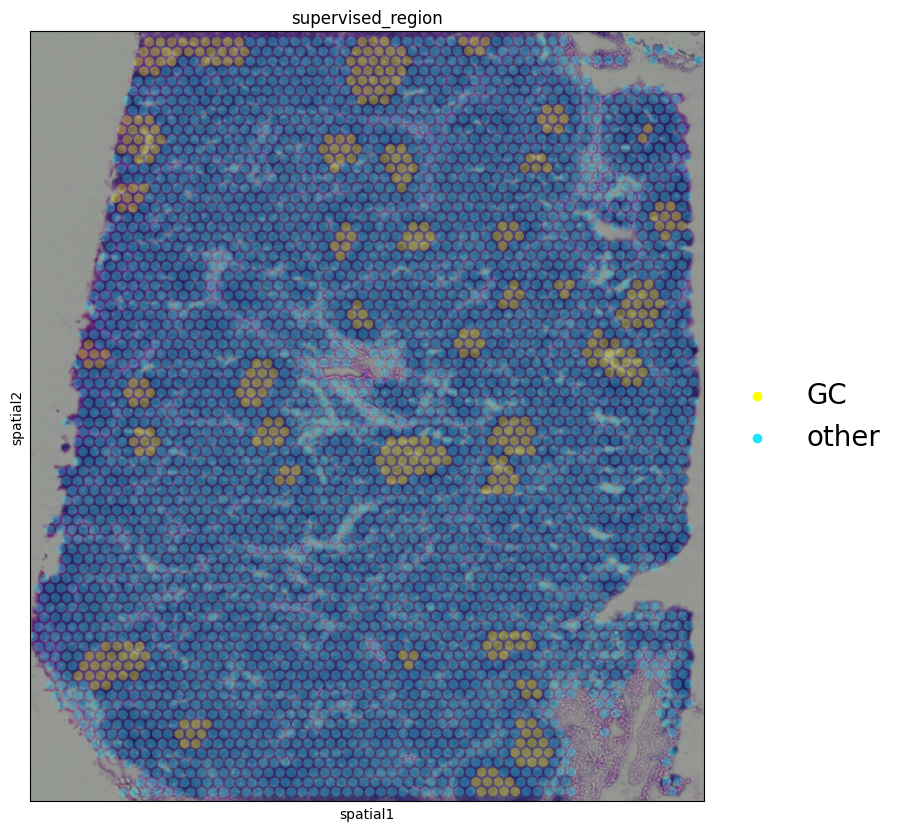

In [11]:
crop_x = [230, 1640]
crop_y = [150, 1760]

max_y = list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape[1]
crop_y = [max_y - i + 80 for i in crop_y]

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (10, 10), 'axes.facecolor': "black"}):
    sc.pl.spatial(adata_vis, cmap='magma',
                  color=['supervised_region'], ncols=4, 
                  size=1.3, img_key='hires', 
                  alpha_img=1, alpha=0.3,
                  frameon=True, legend_fontsize=20,
                  crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', #save='benchmark_supervised_region.pdf',
                  palette=sc.pl.palettes.default_102
                 )

### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [12]:
reg_mod_name = 'RegressionNBV4Torch_57covariates_73260cells_10237genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

In [13]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, ['mean_cov_effect_Subset_'  in i for i in inf_aver.columns]]
from re import sub
inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

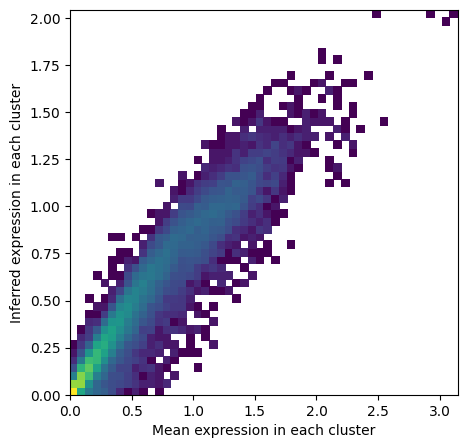

In [14]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'Subset')
aver = aver.loc[adata_snrna_raw.var_names,:]

rcParams["axes.facecolor"] = "white"
with mpl.rc_context({"figure.figsize": (5,5)}):
    plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
               bins=50, norm=mpl.colors.LogNorm());
    plt.xlabel('Mean expression in each cluster');
    plt.ylabel('Inferred expression in each cluster');

# 3. cell2location analysis in one step

Here we perform the first step in one function run - train cell2location model to learn cell locations. Results are shown below and saved to:  

In [15]:
results_folder + 'hyperparameters/'

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/hyperparameters/'

In [16]:
from cell2location.models.LocationModelLinearDependentWMultiExperiment import LocationModelLinearDependentWMultiExperiment

In [17]:
np.random.seed(10)
param_vector = [1, 3, 5, 10, 16, 25, 40, 80]
m_g_param_vector = [0.05, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
param_list = [{k: np.random.choice(param_vector) for k in ['cells_per_spot', 'factors_per_spot', 'combs_per_spot']} 
              for i in range(150)]
for i in range(150):
    param_list[i]['gene_level_prior'] = np.random.choice(m_g_param_vector)

In [ ]:
rcParams['figure.figsize'] = 5, 5
for p in param_list:
    
    r = cell2location.run_cell2location(
                          sc_data=inf_aver,
                          sp_data=adata_vis,
        
                          model_name=LocationModelLinearDependentWMultiExperiment,
        
                          verbose=False, return_all=False,

                          summ_sc_data_args={'cluster_col': "annotation_1"},

                          train_args={'n_iter': 20000, 'learning_rate': 0.005,
                                      'total_grad_norm_constraint': 200,
                                      'sample_prior': False, 'n_prior_samples': 20,
                                      'readable_var_name_col': None,
                                      'sample_name_col': 'sample', 'n_restarts': 1},

                          posterior_args={'n_samples': 1000},
                          export_args={'path': results_folder + 'hyperparameters/',
                                       'save_model': False, 
                                       'run_name_suffix': f'_defaults_ceps{p["cells_per_spot"]}_cps{p["combs_per_spot"]}_fps{p["factors_per_spot"]}_inf_shape01_gl{p["gene_level_prior"]}',
                                       'scanpy_coords_name': 'X_spatial'},
                          model_kwargs={
                                        'cell_number_prior': {'cells_per_spot': p["cells_per_spot"], 
                                                              'factors_per_spot': p["factors_per_spot"], 
                                                              'combs_per_spot': p["combs_per_spot"]
                                                             },
                                        'gene_level_prior': {'mean': p["gene_level_prior"], 
                                                             'sd': p["gene_level_prior"] / 2}
                          }
    )

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps16_fps25_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2053e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps3_fps1_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2076e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps3_fps16_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2041e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps25_fps1_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2005e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps1_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2095e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps5_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.206e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps16_fps40_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2034e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps16_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1999e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps40_fps10_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.1978e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps5_fps10_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2082e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps1_fps3_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2055e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps3_fps40_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2094e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps25_fps40_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2008e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps10_fps25_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2003e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps25_fps40_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2041e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps40_fps40_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1975e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps16_fps3_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2012e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps3_fps80_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.21e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps5_fps10_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2059e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps40_fps25_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.199e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps1_fps40_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2062e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps5_fps16_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2063e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps80_fps3_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.201e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps40_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1985e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps10_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2002e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps80_fps40_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.199e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps3_fps16_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2046e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps1_fps5_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2063e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps25_fps16_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2024e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps1_fps80_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2082e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps16_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2041e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps1_fps5_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2084e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps1_fps25_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2093e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps40_fps25_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1969e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps5_fps25_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2056e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps1_fps10_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2054e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps1_fps16_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2117e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps3_fps40_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2035e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps16_fps80_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2059e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps25_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.202e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps3_fps10_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2111e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps1_fps25_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2129e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps25_fps3_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2024e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps80_fps5_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2001e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps1_fps25_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2087e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps1_fps5_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2114e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps80_fps10_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1966e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps5_fps3_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.207e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps40_fps3_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps3_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.21e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps3_fps3_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2116e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps5_fps3_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2107e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps40_fps5_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.1987e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps16_fps3_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.201e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps80_fps1_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2007e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps1_fps3_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2118e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps40_fps16_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2005e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps1_fps40_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2053e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps40_fps10_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2014e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps10_fps10_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2025e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps40_fps40_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps10_fps5_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.204e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps25_fps25_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.203e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps3_fps10_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2062e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps25_fps40_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2008e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps3_fps25_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2074e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps1_fps10_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2076e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps3_fps25_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.211e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps10_fps25_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2072e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps80_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.1981e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps1_fps25_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2138e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps25_fps80_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2005e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps3_fps10_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2089e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps3_fps40_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2101e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps25_fps40_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1981e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps16_fps3_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2049e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps16_fps40_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2009e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps80_fps10_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1967e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps40_fps80_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2022e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps3_fps10_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2106e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps16_fps16_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2007e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps40_fps40_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.1977e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps5_fps16_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2108e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps5_fps3_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2046e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps3_fps5_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2111e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps5_fps10_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2062e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps16_fps10_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2011e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps80_fps25_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.1974e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps40_fps1_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.1989e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps1_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2101e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps80_fps1_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.1982e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps5_fps40_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2019e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps25_fps1_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2008e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps1_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2098e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps80_fps3_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.1989e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps5_fps25_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.207e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps25_fps10_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2019e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps80_fps1_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.1971e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps40_fps80_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.1986e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps5_fps3_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2025e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps16_fps16_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2045e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps25_fps25_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps5_fps40_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2026e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps1_fps16_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2132e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps5_fps16_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.2049e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps3_fps16_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2058e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps10_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2052e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps3_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2031e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps80_fps3_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.197e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps40_fps10_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2001e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps25_fps80_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.1993e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps16_fps1_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2014e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps1_fps25_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.21e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps16_fps80_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.1995e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps25_fps3_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.1982e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps10_fps5_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2047e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps80_fps25_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.1996e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps25_fps40_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2016e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps40_fps1_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.203e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps40_fps16_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2006e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps3_fps25_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2104e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps10_fps1_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2063e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps3_fps10_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2124e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps40_cps10_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2002e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps25_fps3_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2029e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps1_fps16_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.209e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps40_fps40_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.1987e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps5_fps1_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2079e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps16_fps3_inf_shape01_gl0.5


Finished [100%]: Average Loss = 4.2047e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps40_fps10_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps1_fps80_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2113e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps25_fps40_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.205e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps80_fps10_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.1978e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps3_fps80_inf_shape01_gl0.1


Finished [100%]: Average Loss = 4.2043e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps16_cps1_fps1_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2114e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps5_fps80_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2097e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps40_fps5_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2005e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps40_fps10_inf_shape01_gl1.0


Finished [100%]: Average Loss = 4.2013e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps25_fps40_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.1981e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps16_fps80_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2025e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps1_fps3_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.2128e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps25_fps10_inf_shape01_gl0.3


Finished [100%]: Average Loss = 4.1983e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps3_fps80_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2058e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps5_fps1_inf_shape01_gl0.05


Finished [100%]: Average Loss = 4.2042e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps16_fps5_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2042e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps1_fps80_inf_shape01_gl3.0


Finished [100%]: Average Loss = 4.213e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps10_fps1_inf_shape01_gl1.5


Finished [100%]: Average Loss = 4.2034e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps3_fps25_inf_shape01_gl0.7


Finished [100%]: Average Loss = 4.2118e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps10_fps10_inf_shape01_gl2.0


Finished [100%]: Average Loss = 4.2028e+07


... storing 'sample' as categorical


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps40_fps3_inf_shape01_gl2.0


In [18]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

prefix = 'LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults'
folder_names = [f'{prefix}_ceps{p["cells_per_spot"]}_cps{p["combs_per_spot"]}_fps{p["factors_per_spot"]}_inf_shape01_gl{p["gene_level_prior"]}' for p in param_list]
res = pd.DataFrame(param_list, index=folder_names)
res = res.drop_duplicates()
folder_names = list(res.index)

folder_names_done = [os.path.isfile(f'{results_folder}hyperparameters/{f}/sp.h5ad') for f in res.index]
res.index[~np.array(folder_names_done)], sum(folder_names_done)

(Index([], dtype='object'), 148)

In [19]:
for i, f in enumerate(folder_names):
    
    sp_data_file = f'{results_folder}hyperparameters/{f}/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)
    
    ind = manual_GC_annot.index.isin(adata_vis_res.obs_names)
    ind = manual_GC_annot.index[ind]
    adata_vis_res = adata_vis_res[ind,:]
    adata_vis_res.obs['supervised_region'] = manual_GC_annot.loc[ind, 'GC']
    for ct in gold_standard.index:
        adata_vis_res.obs[ct] = adata_vis_res.obs['supervised_region'].isin([gold_standard.loc[ct, 'label']]).astype(float)
    
    
    adata_vis_res.obs[adata_vis_res.uns['mod']['fact_names']] = adata_vis_res.obs[[f'mean_spot_factors{q}' for q in adata_vis_res.uns['mod']['fact_names']]]
    adata_vis_res.obs[adata_vis_res.uns['mod']['fact_names']] = (adata_vis_res.obs[adata_vis_res.uns['mod']['fact_names']].T / adata_vis_res.obs[adata_vis_res.uns['mod']['fact_names']].sum(1)).T

    from re import sub
    gold_standard_columns = [sub('gold_standard_', '', q) for q in gold_standard.index]

    infer_cell_proportions = adata_vis_res.obs[gold_standard_columns]
    
    # compute PR score
    pos_cell_count = adata_vis_res.obs.loc[infer_cell_proportions.index, gold_standard.index].values
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    mode = 'macro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)
    res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    mode = 'micro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)
    res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    
res

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not 

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not 

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call 

,cells_per_spot,factors_per_spot,combs_per_spot,gene_level_prior,PR_score_macro,ROC_score_macro,PR_score_micro,ROC_score_micro
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps16_fps25_inf_shape01_gl2.0,3,25,16,2.00,0.630736,0.861293,0.582006,0.837373
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps80_cps3_fps1_inf_shape01_gl3.0,80,1,3,3.00,0.708738,0.932992,0.629775,0.890478
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps10_cps3_fps16_inf_shape01_gl0.05,10,16,3,0.05,0.831739,0.966965,0.681943,0.926026
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps25_fps1_inf_shape01_gl1.5,25,1,25,1.50,0.778213,0.960174,0.660678,0.914777
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps3_cps1_fps5_inf_shape01_gl0.05,3,5,1,0.05,0.728725,0.940484,0.638737,0.902341
...,...,...,...,...,...,...,...,...
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps16_fps5_inf_shape01_gl1.5,5,5,16,1.50,0.658773,0.892665,0.600327,0.860787
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps5_cps1_fps80_inf_shape01_gl3.0,5,80,1,3.00,0.629056,0.858368,0.579521,0.835151
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps25_cps10_fps1_inf_shape01_gl1.5,25,1,10,1.50,0.759429,0.954001,0.653064,0.910679
LocationModelLinearDependentWMultiExperiment_1experiments_34clusters_4039locations_10241genes_defaults_ceps1_cps3_fps25_inf_shape01_gl0.7,1,25,3,0.70,0.624739,0.855800,0.579053,0.833475


In [20]:
res.to_csv(f'{results_folder}hyperparameters/summary.csv')

### Look at stability of inference for relative values

In [21]:
fig_path=f'{results_folder}hyperparameters/plots'
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/hyperparameters/plots'

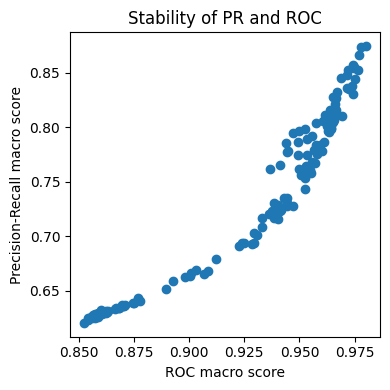

In [22]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['ROC_score_macro'].values.flatten(), 
            res['PR_score_macro'].values.flatten());
plt.xlabel('ROC macro score');
plt.ylabel('Precision-Recall macro score');
plt.title(r'Stability of PR and ROC');
plt.tight_layout()
plt.savefig(fig_path + '/stability_PR_ROC.pdf')

### Ask which parameters - PR score

In [27]:
file = f'{results_folder}hyperparameters/benchmark_objects.p'
results_dict = pickle.load(file = open(file, "rb"))

In [28]:
pos_cell_count

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [25]:
res['method'] = 'cell2location'

for k in results_dict.keys():
    res.loc[k,'method'] = k 
    infer_cell_proportions = results_dict[k][gold_standard_columns]
    
    # compute PR score
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    pos_cell_count = adata_vis_res.obs.loc[infer_cell_proportions.index, gold_standard.index].values
    mode = 'macro'
    res.loc[k, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)
    mode = 'micro'
    res.loc[k, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)

In [34]:
list(results_dict.keys())

['cell2location', 'RCTD', 'scVI_Stereoscope', 'Seurat', 'SPOTlight', 'NNSL']

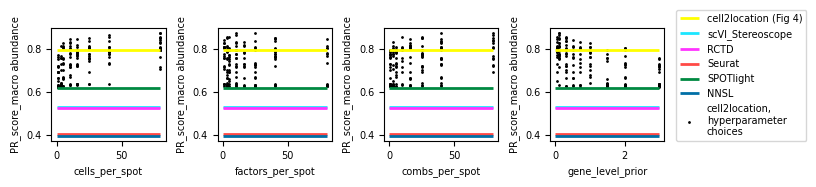

In [37]:
rcParams['figure.figsize'] = 8.2,1.7
rcParams['font.size'] = 7
rcParams["axes.facecolor"] = "white"

mod_names = ['cell2location',
             'scVI_Stereoscope',
             'RCTD',
             'Seurat',
             'SPOTlight',
             'NNSL'
            ]

def plot_hyperparameters(res, mod_names, x_col='cells_per_spot', y_col='relative_r', 
                         legend=False, legend_loc=(1.1, 0)):
    for m, color in zip(mod_names, sc.pl.palettes.default_102):
        label = m
        if m == 'cell2location':
            label = 'cell2location (Fig 4)'
        plt.hlines(res.loc[m, y_col], 
                   xmin=0, xmax=res[x_col].max(), 
                   linewidth=2,
                   colors=color, label=label);

    plt.scatter(res[x_col].values.flatten(), 
                res[y_col].values.flatten(), 
                s=1,
                color='black', label='cell2location,\nhyperparameter\nchoices');

    plt.xlabel(x_col);
    plt.ylabel(f'{y_col} abundance');
    #plt.title(f'{x_col}'+ r' vs $R^2$');
    if legend:
        plt.legend(loc=legend_loc);
    #plt.tight_layout();
    #plt.savefig(f'{fig_path}/stability_{y_col}_vs_{x_col}.pdf')
    #plt.show();
    
    
rcParams['figure.figsize'] = 8.2,1.7
rcParams['font.size'] = 7
rcParams["axes.facecolor"] = "white"
    
y_col='PR_score_macro'

plt.subplot(1, 4, 1)
plot_hyperparameters(res, mod_names, x_col='cells_per_spot', y_col=y_col)
plt.subplot(1, 4, 2)
plot_hyperparameters(res, mod_names, x_col='factors_per_spot', y_col=y_col)
plt.subplot(1, 4, 3)
plot_hyperparameters(res, mod_names, x_col='combs_per_spot', y_col=y_col)
plt.subplot(1, 4, 4)
plot_hyperparameters(res, mod_names, x_col='gene_level_prior', y_col=y_col, 
                     legend=True)


plt.tight_layout();
plt.savefig(f'{fig_path}/stability_{y_col}.pdf')
plt.show();

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass